### Homework 4
Felipe Alves - N14713445


#### Question 
Show the downward bias of the OLS estimate of $\alpha$ in the AR1 process

$$ X_{t+1} = \beta + \alpha X_{t} + \sigma W_{t+1}, \quad \{W_t\} \sim \mathcal{N}(0,1) $$

for sample sizes $n=50,100,150, \ldots, 500$. 

In [1]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import randn
from scipy.stats import linregress
from scipy.linalg import inv
from numba import jit


In [2]:
@jit
def ar1_sim(bet,alp,sig,n):
    """
    Simulates an AR(1) of form 
    
    .. math::

    X_{t+1} = β + α X_t + σ W_{t+1}
    
    and return { X }_{t=0}^{T} and { X }_{t=1}^{T+1}
    for regression
    """
    eps = randn(n)
    x = np.zeros(n+1)
    x[0] = bet/(1-alp)
    for i in range(n):
        x[i+1] = bet + alp*x[i] + eps[i]

    return x[0:-1],x[1:]

I tested two alternative 

  * My jit ar1_sim function 
  
  * ARMA class in the Quan Econ packages
  
testing how much time it takes to simulate the series

In [3]:
timeit y = ar1_sim(0.0,0.5,1.0,int(10**6))

The slowest run took 8.43 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 44.3 ms per loop


In [4]:
lp = qe.ARMA(0.5)

%time data = lp.simulation(int(10**6))

CPU times: user 11.3 s, sys: 109 ms, total: 11.4 s
Wall time: 11.4 s


Therefore, since the exercise deal with a specific AR(1) process we don't need 
the generality offered by the ARMA class and can work with 
the simple ar1_sim function, that has the benefit of being way faster. 

In [5]:
def alp_hat(alp,n,N):
    alp_hat = 0.0
    for k in range(N):                
        x,y = ar1_sim(0.0,alp, 1.0, n)
        alp_hat += ols(x,y,n)[1]

    return alp_hat/N

alp_hat_numba = jit(alp_hat)  

def ols(x,y,n):
    b0 = np.ones(n)
    X = np.concatenate((b0, x))
    XT = X.reshape(2,n)
    X = XT.T
    alp_hat = np.dot(inv(np.dot(XT,X)),(np.dot(XT,y)))
    
    return alp_hat


In [6]:
timeit α = alp_hat(0.5,100,10000)

1 loops, best of 3: 1.32 s per loop


In [7]:
timeit α = alp_hat_numba(0.5,100,10000)

1 loops, best of 3: 1.44 s per loop


In [8]:
def main(Eα̂, A, nsize, N=1000, print_plot = True):
    """
    Compute the bias for different levels of 
    parameter α and sample size n
    
    """
    for j,alp in enumerate(A):
        i=0
        for n in nsize:
            Eα̂[j,i] = alp_hat(alp,n,N)
            i+=1

    if print_plot:
        fig,ax = plt.subplots(figsize =(8,5))
        for i,α in enumerate(A):
            current_label = r'$\alpha = {0:.1f}$'.format(α)
            ax.plot(list(nsize),Eα̂[i,:]-α, 'o', alpha = 0.7, label=current_label)
        ax.legend(loc='lower right')
        ax.set_xlabel(r'Sample Size')
        ax.set_ylabel(r'Bias')
        plt.show

In [9]:
main??

CPU times: user 1min 6s, sys: 451 ms, total: 1min 7s
Wall time: 1min 7s


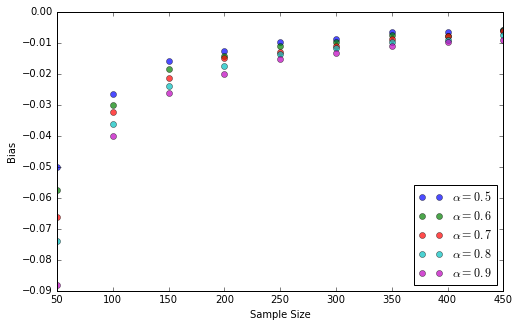

In [10]:
%matplotlib inline

# α values
A =  (0.5,0.6,0.7,0.8,0.9)
# Sample size
nsize = range(50,500,50)

# OLS estimates
Eα̂ = np.zeros((len(A),len(nsize)))

%time main(Eα̂,A,nsize,10000)